In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
#ls ../input
submission_mode = True

In [3]:
project_folder = '../input/cassava-leaf-disease-classification'
df = pd.read_csv(f'{project_folder}/train.csv')
df['image_path'] = df['image_id'].apply(lambda x : f'{project_folder}/train_images/{x}')

In [4]:
df.head()

,image_id,label,image_path
0,1000015157.jpg,0,../input/cassava-leaf-disease-classification/t...
1,1000201771.jpg,3,../input/cassava-leaf-disease-classification/t...
2,100042118.jpg,1,../input/cassava-leaf-disease-classification/t...
3,1000723321.jpg,1,../input/cassava-leaf-disease-classification/t...
4,1000812911.jpg,3,../input/cassava-leaf-disease-classification/t...


In [5]:
from PIL import Image
image1 = Image.open(df['image_path'].tolist()[0])

In [6]:
import numpy as np
def get_random_crops(img):
    imgs = []
    for i in range(5):
        cropped_img = tf.image.random_crop(img, size = [512,512,3])
        imgs.append(cropped_img)
    return imgs
        
images = get_random_crops(np.array(image1))

In [7]:
def get_augmented_images(img):
    img = np.array(img)
    imgs = []
    cropped_images = get_random_crops(img)
    for cropped_img in cropped_images:
        

        horizontal_flip = np.random.rand() > 0.5
        vertical_flip   = np.random.rand() > 0.5
        
        aug_img = tf.keras.preprocessing.image.random_shear(cropped_img, 0.20)
        if horizontal_flip: aug_img = tf.image.flip_left_right(aug_img)
        if vertical_flip: aug_img = tf.image.flip_up_down(aug_img)
            
            
        imgs.append(aug_img)
    return imgs
        

In [8]:
images = get_augmented_images(image1)
tmp_img = image1.resize((512,512))
tmp_img = np.array(tmp_img)
images.append(tmp_img)

In [9]:
np.array(images).shape

(6, 512, 512, 3)

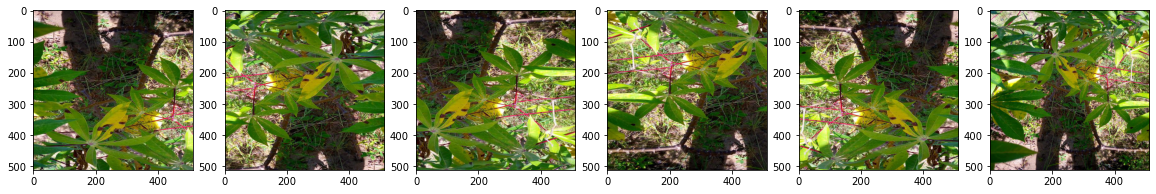

In [10]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1,6, figsize=(20,20)) 
for i in range(6):
    axarr[i].imshow(images[i])
#plt.imshow(images[0])

In [11]:
datagen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True,shear_range = 0.2, rotation_range=25,
                                channel_shift_range =0.2,zoom_range=0.2, height_shift_range =0.2,
                                     vertical_flip = True, validation_split = 0.2)

In [12]:
df['label'] = df['label'].astype(str)
img_size = 512

train_datagen = datagen.flow_from_dataframe(df, x_col = 'image_path', y_col = 'label', batch_size = 8, 
                                               class_mode = 'categorical', target_size = (img_size, img_size),
                                                  subset = 'training')

Found 17118 validated image filenames belonging to 5 classes.


In [13]:
val_datagen = datagen.flow_from_dataframe(df, x_col = 'image_path', y_col = 'label', batch_size = 8, 
                                            class_mode = 'categorical', target_size = (img_size, img_size),
                                              subset = 'validation')

Found 4279 validated image filenames belonging to 5 classes.


In [14]:
if submission_mode:
    def create_pretrained_model():

        pretrained_model = tf.keras.applications.EfficientNetB3(weights = '../input/efficientnet-model-file/efficientnetb3_notop.h5', 
                                                                    include_top=False,drop_connect_rate=0.4,  
                                                                        input_shape=(img_size, img_size, 3))

        x = layers.GlobalAveragePooling2D()(pretrained_model.output)

        x = layers.Dense(512, activation= 'relu')(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(5, activation='softmax')(x)


        model = tf.keras.models.Model(inputs=pretrained_model.input, outputs=x)

        decay_steps = int(round(17118.0/8.0))*3
        cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

        callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

        model.compile(optimizer=tf.keras.optimizers.Adam(cosine_decay), loss='categorical_crossentropy', metrics=['accuracy'])
        return model


    model     = create_pretrained_model()
    callbacks = [ModelCheckpoint(filepath='best_model_final.h5', monitor='val_loss', save_best_only=True)]
    history   = model.fit(train_datagen, epochs = 3, validation_data = val_datagen, callbacks = callbacks)

Epoch 1/3
2140/2140 [==============================] - 1886s 874ms/step - loss: 0.7107 - accuracy: 0.7444 - val_loss: 1.6453 - val_accuracy: 0.2557
Epoch 2/3
2140/2140 [==============================] - 1824s 852ms/step - loss: 0.4385 - accuracy: 0.8490 - val_loss: 0.6291 - val_accuracy: 0.7705
Epoch 3/3
2140/2140 [==============================] - 1825s 852ms/step - loss: 0.3623 - accuracy: 0.8744 - val_loss: 0.3909 - val_accuracy: 0.8729


In [15]:
if submission_mode:
    model = tf.keras.models.load_model('best_model_final.h5')
else:
    model = tf.keras.models.load_model('../input/best-model/best_model.h5')
#model.save('best_model_final.h5')

In [16]:
from PIL import Image

In [17]:
test_image_path = df['image_path'].tolist()[4]
img = Image.open(test_image_path)
img = img.resize((512,512))

In [18]:
import numpy as np
img = np.array(img)

In [19]:
img = img / 255.0

In [20]:
imgs = get_random_crops(img)
imgs = np.array(imgs)

In [21]:
preds = model.predict(imgs)

In [22]:
preds = np.argmax(np.sum(preds, axis=0))

In [23]:
preds

3

In [24]:
df.head()

,image_id,label,image_path
0,1000015157.jpg,0,../input/cassava-leaf-disease-classification/t...
1,1000201771.jpg,3,../input/cassava-leaf-disease-classification/t...
2,100042118.jpg,1,../input/cassava-leaf-disease-classification/t...
3,1000723321.jpg,1,../input/cassava-leaf-disease-classification/t...
4,1000812911.jpg,3,../input/cassava-leaf-disease-classification/t...


In [25]:
test_folder = '../input/cassava-leaf-disease-classification/test_images'

In [26]:
import os
test_files = os.listdir(test_folder)

In [27]:
test_files

['2216849948.jpg']

In [28]:
submission_df = pd.DataFrame()
image_names = []
predictions = []

for img_name in test_files:

    tmp_img = Image.open(f'{test_folder}/{img_name}')
    
    aug_imgs = get_augmented_images(tmp_img)
    
    tmp_img = tmp_img.resize((512,512))
    tmp_img = np.array(tmp_img)
    
    aug_imgs.append(tmp_img)
    imgs    = np.array(aug_imgs)
    
    imgs    = imgs/ 255.0
    
    
    
    preds   = model.predict(imgs)
    prediction = np.argmax(np.sum(preds, axis=0))
    image_names.append(img_name)
    predictions.append(prediction)
    
submission_df = pd.DataFrame( data = {'image_id' : image_names, 'label' : predictions})
    

In [29]:
submission_df

,image_id,label
0,2216849948.jpg,4


In [30]:
submission_df.to_csv("submission.csv", index=False) 